### PyTorch Autograd - automatic differentiation engine

[PyTorch 101, Part 1: Understanding Graphs, Automatic Differentiation and Autograd](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/)

В центре большинства современных приемов машинного обучения лежит расчет градиентов. Это в особенности касается нейронных сетей, где для обновления весовых коэффициентов используется алгоритм обратного распространения

Autograd предоставляет классы и функции, реализующие автоматическое дифференцирование произвольных скалярных функций. Это требует минимальных изменений в существующем коде - нужно только объявить Tensor, для которого должны вычисляться градиенты, с атрибутом `requires_grad=True`

In [1]:
import torch

In [2]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [3]:
x.grad == None

True

In [4]:
x.grad_fn == None

True

После применения какой-либо операции к тензору атрибуту `grad_fn`  присваивается объект `Function`, который добавляется в граф вычислений для обратного распространения градиента.



In [5]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [6]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


`.grad_fn` может менять "на лету"

In [7]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


Метод `backward` корневого узла графа вычислений запускает процедуру вычисления градиентов в листовых (is_leaf) узлах, имеющих атрибут requires_grad. Граф дифференцируется по цепочке (chain rule)

In [8]:
out.backward()

In [9]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


По умолчанию промежуточные (не листовые) узлы графа не хранят прошедшие через них градиентов.

In [10]:
print(y.grad)

None


<ipython-input-10-b81046718426>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(y.grad)


Эту ситуацию можно изменить, вызвав для для конкретного узла метод retain_grad

In [11]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
y.retain_grad()
z = y * y * 3
out = z.mean()
out.backward()

In [12]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [13]:
print(y.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


Иногда с листовыми узлами необходимо проделать действия, не меняя при этом графа. Такие действия проводят, используя контекстный менедежр `no_grad`, которое блокирует создание новых узлов графа

In [14]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad(): # потом можно включить вручную torch.enable_grad()
    print((x ** 2).requires_grad)


True
True
False


### Micrograd

[micrograd](https://github.com/karpathy/micrograd)

In [15]:
!git clone https://github.com/karpathy/micrograd.git

Cloning into 'micrograd'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 98 (delta 39), reused 38 (delta 38), pack-reused 38 (from 1)
Receiving objects: 100% (98/98), 258.88 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [16]:
%cd micrograd

/content/micrograd


In [18]:
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP, Module

from sklearn.datasets import make_moons, make_blobs

In [19]:
np.random.seed(42)
random.seed(42)

#### Пример построения графа вычислений

In [20]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [21]:
Value??

Для отслеживания, как считаются градиенты в примере ниже, временно "пропатчим" функции `__add__`, `__mul__`, `relu` и `backward` из класса `Value` так, чтобы видеть, в логах как применяются операции

In [22]:
old_relu = Value.relu
old_backward = Value.backward
old_add = Value.__add__
old_mul = Value.__mul__

def new_relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    def _backward():
        self.grad += (out.data > 0) * out.grad
        print(f"""
          Считаем производную relu:
          входной градиент = {out.grad}
          локальный градиент = {int(out.data > 0)}
          выходной градиент = {out.grad} * {int(out.data > 0)} = {self.grad}
          """
        )
    out._backward = _backward

    return out

def new_mul(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad

        print(f"""
          Считаем производную умножения.
          Для умножения локальный градиент по отношению к какому-либо из входов будет равен значению оставшегося входа:
          входной градиент = {out.grad}
          локальный градиент для первого множителя = {other.data}
          локальный градиент для второго множителя = {self.data}
          выходной градиент для первого множителя = {out.grad} * {other.data} = {self.grad}
          выходной градиент для второго множителя = {out.grad} * {self.data} = {other.grad}
          """
        )
    out._backward = _backward

    return out


def new_add(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
        self.grad += out.grad
        other.grad += out.grad

        print(f"""
          Считаем производную сложения.
          Относительно каждого из входов локальный градиент в вершине суммирования будет равен  1.
          входной градиент = {out.grad}
          локальный градиент для первого слагаемого = 1
          локальный градиент для второго слагаемого = 1
          выходной градиент для первого слагаемого = 1 * {out.grad}
          выходной градиент для второго слагаемого = 1 * {out.grad}
          """
        )
    out._backward = _backward

    return out

def new_backward(self):

    # topological order all of the children in the graph
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    # go one variable at a time and apply the chain rule to get its gradient
    self.grad = 1
    print("""
      Начинаем обратное распространение.

      На каждом шаге метода обратного распространения будем считать выходной градиент как входной * локальный.
      Входной градиент - градиент с прошлого шага метода обратного распространения.
      Локальный градиент - значение производной элементарной функции на данном шаге.
      Входной градиент на первом шаге = 1 (так как df/df = 1).
      """
    )
    for v in reversed(topo):
        v._backward()

In [23]:
Value.relu = new_relu
Value.backward = new_backward
Value.__add__ = new_add
Value.__mul__ = new_mul


      Начинаем обратное распространение.
      
      На каждом шаге метода обратного распространения будем считать выходной градиент как входной * локальный.
      Входной градиент - градиент с прошлого шага метода обратного распространения.
      Локальный градиент - значение производной элементарной функции на данном шаге.
      Входной градиент на первом шаге = 1 (так как df/df = 1).
      

          Считаем производную relu: 
          входной градиент = 1
          локальный градиент = 1
          выходной градиент = 1 * 1 = 1
          

          Считаем производную сложения.
          Относительно каждого из входов локальный градиент в вершине суммирования будет равен  1.
          входной градиент = 1
          локальный градиент для первого слагаемого = 1
          локальный градиент для второго слагаемого = 1
          выходной градиент для первого слагаемого = 1 * 1
          выходной градиент для второго слагаемого = 1 * 1
          

          Считаем производную умнож

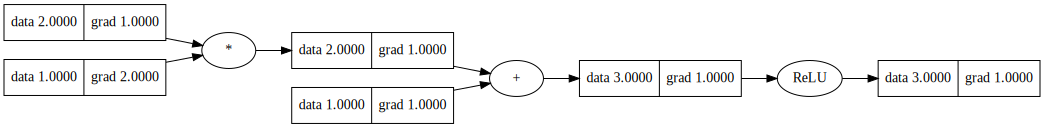

In [24]:
x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

Вернем старые реализации функций обратно, чтобы при обучении модели не утонуть в логах

In [25]:
Value.relu = old_relu
Value.backward = old_backward
Value.__add__ = old_add
Value.__mul__ = old_mul

In [23]:
Neuron??

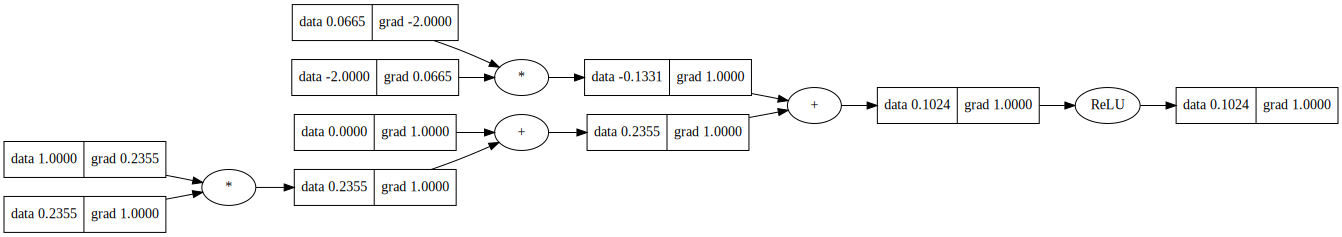

In [26]:
random.seed(1337)
n = Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot

#### MLP для бинарной классификации

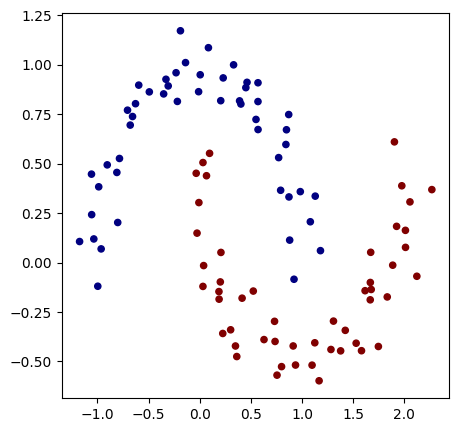

In [27]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [28]:
X[0], y[0]

(array([ 1.58202308, -0.44581483]), 1)

In [28]:
MLP??

In [29]:
Layer??

In [30]:
Module??

In [29]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print("number of parameters", len(model.parameters()))

number of parameters 337


In [30]:
model.layers

[Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)],
 Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)],
 Layer of [LinearNeuron(16)]]

In [31]:
# посчитаем параметры
(2 * 16 + 16) + (16 * 16 + 16) + (16 * 1 + 1)

337

In [32]:
def loss(batch_size=None):
    Xb, yb = X, y
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi * score_i).relu() for yi, score_i in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (score_i.data > 0) for yi, score_i in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.41454652413193865, grad=0) 0.82


In [33]:
for k in range(100):
    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.41454652413193865, accuracy 82.0%
step 1 loss 0.7863805046215181, accuracy 81.0%
step 2 loss 0.461961145267714, accuracy 83.0%
step 3 loss 0.5085892319645842, accuracy 83.0%
step 4 loss 0.31049052687261214, accuracy 86.0%
step 5 loss 0.2689947571730255, accuracy 89.0%
step 6 loss 0.24554659072506863, accuracy 89.0%
step 7 loss 0.23622330038400666, accuracy 90.0%
step 8 loss 0.21720946703312552, accuracy 90.0%
step 9 loss 0.21400559443772385, accuracy 91.0%
step 10 loss 0.20939260057894807, accuracy 91.0%
step 11 loss 0.3300210916807542, accuracy 92.0%
step 12 loss 0.38174928707618516, accuracy 87.0%
step 13 loss 0.4508064668364713, accuracy 85.0%
step 14 loss 0.24799516110878045, accuracy 89.0%
step 15 loss 0.19302863848938961, accuracy 91.0%
step 16 loss 0.18158693713880056, accuracy 93.0%
step 17 loss 0.18371866789300473, accuracy 94.0%
step 18 loss 0.17646529149266213, accuracy 92.0%
step 19 loss 0.2118644238610899, accuracy 95.0%
step 20 loss 0.23740708747640143, accu

(-1.5978882018302847, 2.1521117981697153)

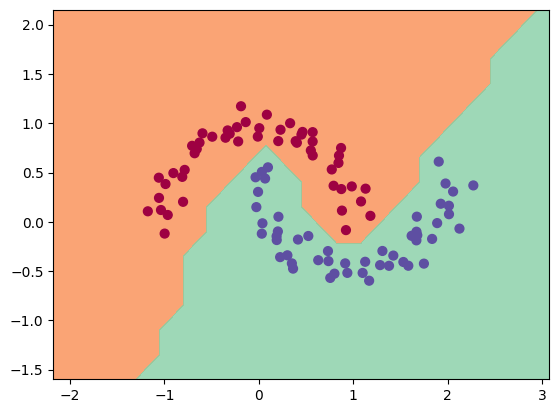

In [34]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())